In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_stat_map, view_img
from nilearn.reporting import get_clusters_table
import glob
import os
import numpy as np
import pandas as pd

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
from fmri_nb_helpers import get_img_path, get_filt_tval_img, plot_filt_tval_img, get_filt_diff_tval_img, plot_filt_diff_tval_img, get_mean_cor_df

# Regressor types

- ev = event; amplitude = 1  
- par = parametric; amplitude = demeaned    
- st = stick (0 duration); amplitude = 1 
- rt = reaction time; amplitude = demeaned RT

Citing Grinband et al. (2008) people agree that reaction times must be taken into account but model them in different ways. Schonberg, Poldrack et al. papers use overall response time for event and parametric regressor as well as a parametric RT regressor. Many in the rest of the decision making literature use boxcars with RT durations (e.g. Dunsmoor et al. (2011), Chang et al. (2011), Chang and Sanfey (2013), Shuck et al. (2016)). 

Since it is common to use boxcars with RT duration and I don't know others who model RT the way Poldrack et al. do I will present those results below.

# Model 1: fractalProb_ev + stim_ev + choiceShift_st + reward_ev

Correlation between regressors averaged across subjects and runs

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "1")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'reward_ev']
mnum = '1'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

Check for left motor cortex activity. Cross is the precentral gyrus peak reported in Hare et al.

In [ ]:
reg = 'choiceShift_st'
mnum = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

plot_filt_tval_img(reg, mnum = mnum, cut_coords = cut_coords, draw_cross = draw_cross)

Motor cortex activity is a little ventral than expected but more consistent for choiceShift regressor. It is, however, not lateralized to the left.

# Model 1a: fractalProb_ev + stim_ev + choiceShiftLeft_st + choiceShiftRight_st + reward_ev

In [ ]:
plot_filt_diff_tval_img(reg="choiceShiftLeft_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1a", reg2 = "choiceShiftLeft_st", cut_coords = cut_coords)


# Model 2: Model 1 + fractalProb_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "2")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '2'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))

In [ ]:
reg = 'fractalProb_par'
mnum = '2'
plot_filt_tval_img(reg, mnum = mnum)

# Model 3: Model 2 + valBundleSum_par + valChosenMinusUnchosen_par + reward_ev + reward_par + rpeLeftRightSum_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "3")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '3'

for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valChosenMinusUnchosen_par, model = 3, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeLeftRightSum_par, model = 3, tstat = 1, reg_rt = 0 at threshold p < 0.05


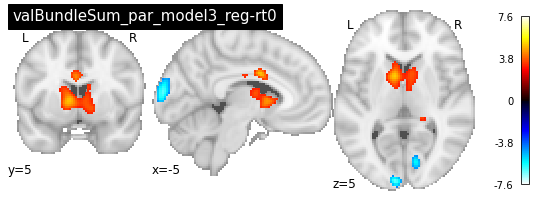

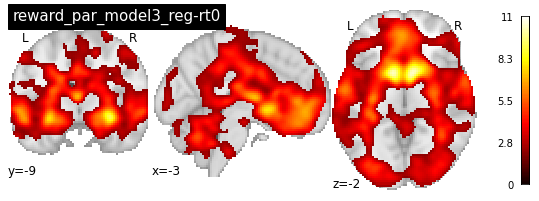

In [3]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par']
mnum = '3'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

## What is going on with reward_par? 

The tvalue image looks a lot more reasonable. The corrected p image is where things get insane.

From Winkler et al. (2014) where the `randomise` algorithm is described: 

>>
As the statistics Tj∗ are calculated for each shuffling to build the reference distribution at each point, the maximum value of Tj∗ across the image, Tjmax, is also recorded for each rearrangement, and its empirical distribution is obtained. For each test in the image, an fwer-corrected p-value can then be obtained by computing the proportion of Tjmax that is above T0 for each test. A single fwer threshold can also be applied to the statistical map of T0 values using the distribution of Tjmax
>>
...
>>
Consider a multi-subject fmri study to investigate the bold response associated with a novel experimental task. After the first-level analysis (within subject), maps of contrasts of parameter estimates for each subject are used in a second level analysis. The regressor for the effect of interest (the mean effect) is simply a column of ones; nuisance variables, such as handedness, can be included in the model. Permutations of the data or of the design matrix do not change the model with respect to the regressor of interest. However, by treating the errors as symmetric, instead of permutation, the signs of the ones in the design matrix, or of each datapoint, can be flipped randomly to create the empirical distribution from which inference can be performed.
>>

Plotting tvalues filtered for corrected p values < 0.05


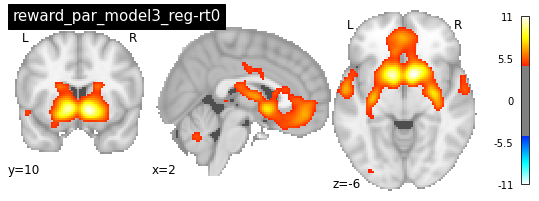

In [4]:
plot_filt_tval_img("reward_par", mnum = "3", nofilt=True, t_threshold=4.6) #critical value from logs
# plot_filt_tval_img("reward_par", mnum = "3", nofilt=True, t_threshold=2)

In [5]:
tmp = get_filt_tval_img("reward_par", mnum = "3", mname = 'overall-mean', nofilt=True)
print(np.min(tmp.get_fdata()), np.max(tmp.get_fdata()))

-3.9426794052124023 11.017919540405273


In [6]:
reg = "reward_par"
mnum = "3"
mname = 'overall-mean'
reg_rt = '0'
tstat='1'

In [7]:
level3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/'
model_path = 'model'+mnum+'_reg-rt'+reg_rt
img_path = os.path.join(level3_path, model_path, mname, reg+'_'+model_path)

pos_pval_fn = 'rand_tfce_corrp_tstat%s_pos_%s_%s_model%s_reg-rt%s.nii.gz'%(tstat, mname, reg, mnum, reg_rt)
neg_pval_fn = 'rand_tfce_corrp_tstat%s_neg_%s_%s_model%s_reg-rt%s.nii.gz'%(tstat, mname, reg, mnum, reg_rt)

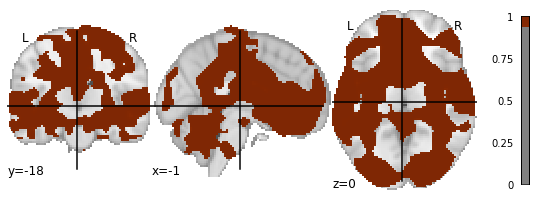

In [8]:
plot_stat_map(os.path.join(img_path, pos_pval_fn), threshold=.95, cmap="Oranges")

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:140: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  warnings.warn(
/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


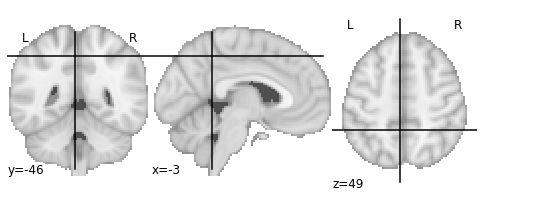

In [9]:
plot_stat_map(os.path.join(img_path, neg_pval_fn), threshold=.95, cmap="Blues")

# Model 5: Model 2 + valBundleSum_par + valChosenMinusUnchosenLate_par + reward_ev + reward_par + rpeLeftRightSumEarly_par

In [ ]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumEarly_par']
mnum = '5'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "5", nofilt=True, t_threshold=3, cut_coords=(-52, -48, 48))
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "5", nofilt=True, t_threshold=3, cut_coords=(24, 12, 6))
plot_filt_tval_img("rpeLeftRightSumEarly_par", mnum = "5", nofilt=True, t_threshold=3)

# Model 6: Model 2 + valBundleSum_par + valChosenMinusUnchosenLate_par + reward_ev + reward_par + rpeLeftRightSumLate_par

In [ ]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumLate_par']
mnum = '6'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "6", nofilt=True, t_threshold=3)
plot_filt_tval_img("rpeLeftRightSumLate_par", mnum = "6", nofilt=True, t_threshold=3)

# Model 7: what happens to rpe without reward_par - nothing. Still doesn't survive.

In [ ]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosen_par', 'rpeLeftRightSum_par']
mnum = '7'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("rpeLeftRightSum_par", mnum = "7", nofilt=True, t_threshold=2.3)
plot_filt_tval_img("valChosenMinusUnchosen_par", mnum = "7", nofilt=True, t_threshold=3)

# Model 8: what happens to reward_par when not centered - nothing. Same as before.

In [ ]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosen_par', 'rewardNotDemeaned_par', 'rpeLeftRightSum_par']
mnum = '8'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

# Model 9: Does anything for rpe survive with only one fractal included? No.

In [ ]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftFractal_par']
mnum = '9'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("rpeLeftFractal_par", mnum = "9", nofilt=True, t_threshold=3)

# To solve

- Value comparison
- Signal for learning (RPE)
    - Same RPE regressor for all subjects using average parameter estimates?
- Parametric reward
    - Reward par for rewarded vs not rewarded contrast?